# Aggregazione limitata dalla diffusione

In questo esercizio si vuole effettuare una simulazione Monte Carlo del processo di aggregazione limitata dalla diffusione.

## Introduzione

Il processo di aggregazione limitata dalla diffusione (noto come DLA, **diffusion limited aggregation**) consiste nella formazione di strutture dovuto al deposito di particelle il cui moto, prima della aggregazione, si può considerare casuale (moto Browniano).

In questo esercizio viene simulata una versione semplificata di questi processi. Infatti si considera il processo di DLA in uno spazio bidimensionale ed in particolare si utilizza un reticolo quadrato a passo fisso (che verrà rappresentato internamente da una matrice). 

Inoltre il moto delle particelle viene approssimato da un _random walk_. Queste ultime vengono simulate una per volta e pertanto non ci sono interazioni fra le particelle. In ogni ciclo viene creata (emessa) una particella in certi siti (sorgenti) e fatta evolvere fino alla aggregazione con altre particelle dei cicli precedenti o alla fuoriuscita dal reticolo. 

Per questa ragione, perchè possa avere inizio il processo di aggregazione, è necessario che esistano dei siti di aggregazione anche in mancanza di particelle (diversamente la prima continuerebbe a muoversi senza fine). La geometria dei siti di emissione e di questi siti di aggregazione primaria determina il risultato della simulazione.

In questo esercizio vengono simulate due diverse configurazioni per le sorgenti ed i nuclei di aggregazione.

## Operazioni preliminari

I generatori di numeri pseudocasuali utilizzati in questo esercizio sono contenuti nel sottomodulo `numpy.random`, questi ultimi, analogamente a quelli contenuti nel modulo `random`, sono basati sull'algoritmo _Mersenne Twister_. 

Si osserva che il seme per questi generatori di numeri pseudocasuali viene automaticamente impostato su un valore anch'esso casuale, pertanto, ad ogni esecuzione del codice, il risultato della simulazione è diverso dalla precedente.

In [1]:
# importing modules
import numpy as np
import numpy.random as rnd

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image

# display configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
from base64 import b64encode
from IPython.display import HTML

def video(filename):
    video_tag = '''<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>'''
    raw = open(filename,'rb').read()
    encoded = b64encode(raw)
    encoded_ascii = video_tag.format(encoded.decode('ascii'))
    return HTML(data=encoded_ascii)

Gli unici parametri di questa simulazione sono le dimensioni della griglia.

In [3]:
n = 50 # number of rows
m = 50 # number of columns

## Implementazione

Si decide di incapsulare lo stato del sistema e l'algoritmo di evoluzione in oggetti, viene pertanto implementata la classe `DLAProcess`. Inoltre si implementano due classi aggiuntive, `Particle` e `Source`, per rappresentare rispettivamente le particelle, prima della loro aggregazione, e le sorgenti. Le classi `DLAProcess` e `Source` verranno successivamente specializzate in sottoclassi per simulare due configurazioni particolari.

Si fanno le seguenti precisazioni preliminari. I siti di emissione sono rappresentati internamente tramite una matrice, i cui elementi sono in corrispondenza con i siti di emissione sul reticolo. In particolare, indicando con $S$ questa matrice, allora $S_{ij} = 1$ se il nodo $(i,j)$ sul reticolo è un sito di emissione, altrimenti $S_{ij} = 0$.

In secondo luogo anche il reticolo su cui avviene il processo di aggregazione viene rappresentato da una matrice. Gli elementi di questa matrice sono in corrispondenza con i nodi del reticolo in maniera analoga alla matrice dei siti di emissione, tuttavia i nodi di questo reticolo possono trovarsi in 3 stati diversi a cui corrispondono i valori

- $0$ : il sito è vuoto 
- $1$ : il sito è occupato
- $2$ : il sito è _appiccicoso_, ovvero una particella in transito su un sito in questo stato vi rimane bloccata

Per come è definito il processo i siti occupati sono circondati da altri siti occupati o da siti appiccicosi.

A questo punto si può commentare l'implementazione del metodo `evolve` della classe `DLAProcess`. Ques'ultimo contiene l'algoritmo di evoluzione del sistema, che consiste delle seguenti operazioni:

1. Selezionare un sito di emissione a caso fra quelli disponibili con uguale probabilità.
2. Creare una particella nel sito di emissione selezionato.
3. Lasciar evolvere la particella fintanto che non passi per un sito appiccicoso oppure esca dal reticolo (caso in cui si riparte dal punto 1).
4. Cambiare lo stato dove si è fermata la particella in occupato.
5. Generare i siti appiccicosi nell'intorno del sito occupato.
6. Se necessario aggiornare la posizione dei siti di emissione (questo punto diventerà più chiaro in merito alla seconda configurazione simulata).
7. Verificare che uno dei siti di emissione non coincida con un sito appiccicoso, in caso affermantivo terminare l'evoluzione del sistema (nel caso specifico restituire un booleano).

Si osserva che la classe `DLAProcess` contiene anche il metodo `draw` per disegnare lo stato del sistema. Opzionalmente, essendo conservata in una seconda matrice il tempo (ovvero il ciclo di iterazione) in cui un sito diventa occupato, è possibile rappresentare lo stato del sistema nel tempo tramite una immagine a colori (utilizzando lo schema di colori `rainbow` i siti occupati per primi hanno colori tendenti verso il violetto, quelli più giovani verso il rosso).

In [4]:
class Source:

    def __init__(self):
        raise NotImplementedError
    
    def site_pick(self):
        return self.sitelist[rnd.randint(self.sitenumber)]
    
    def update(self,dlagrid):
        raise NotImplementedError
        

class Particle:
    
    moves = (-1, 0), (0, 1), (1, 0), (0, -1)
    
    def __init__(self,s):
        self.site = s.site_pick()
    
    def move(self):
        dx, dy = self.moves[rnd.randint(4)]
        self.site = self.site[0]+dx, self.site[1]+dy
    
    
class DLAProcess:
    
    cmColor = cm.get_cmap('rainbow')
    cmColor.set_under('w')
    cmMono = cm.get_cmap('Greys')
    cmMono.set_under('w')
        
    def __init__(self):
        raise NotImplementedError
    
    def get_site(self,p):
        return self.grid[p.site]
    
    def inbound(self,x,y=None):
        if y == None:
            a, b = x.site
        else:
            a, b = x, y
        return 0 <= a < self.grid.shape[0] and 0<= b < self.grid.shape[1]
    
    def update(self,p):
        self.grid[p.site] = 1
        self.agegrid[p.site] = self.counter
        self.counter += 1
        
    def update_stiky_neighbors(self,site):
        x, y = site
        for i in [x-1,x,x+1]:
            for j in [y-1,y,y+1]:
                if self.inbound(i,j) and (i,j) != (x,y) and self.grid[i,j] == 0:
                    self.grid[i,j] = 2
                    
    def evolve(self,source):
        # Pick a generation site at random and create there a particle.
        p = Particle(source)
        # Evolve the particle state until it goes on a sticky site or leave the grid.
        while self.get_site(p) != 2:
            p.move()
            # If the particle is inside the grid then it's also on a sticky site
            if not self.inbound(p):
                p = Particle(source)
        # Update the site state, mark as occupied
        self.update(p)
        # Update sticky neighbors sites
        self.update_stiky_neighbors(p.site)
        # Eventually move the sources
        source.update(self.grid)
        
        self.stop = np.any([self.grid[z] == 2 for z in source.sitelist])
    
    def draw(self,opt='mono'):
        if opt=='mono':
            monogrid = np.empty_like(self.grid)
            for z in np.ndindex(monogrid.shape):
                monogrid[z] = (1 if self.grid[z] == 1 else 0)
            return plt.imshow(monogrid,interpolation='none',vmin=0.5,cmap=self.cmMono)
        elif opt == 'color':
            colorgrid = np.copy(self.agegrid)
            return plt.imshow(colorgrid,interpolation='none',vmin=0.5,cmap=self.cmColor)

## Configurazione 1

In questa configurazione esiste un solo sito di emissione al centro del reticolo mentre sugli spigoli i siti sono nello stato appiccicoso. Né la posizione né il numero di sorgenti cambia durante la simulazione, pertanto quest'ultima si interrompe quando l'ultima particella ad aggregarsi si trova in un sito adiacente a quello centrale.

In [5]:
class Type1Source(Source):

    def __init__(self):
        self.grid = np.zeros([2*n+1,2*m+1],dtype=int)
        self.grid[n,m] = 1
        i, j = np.where(self.grid != 0)
        self.sitelist = list(zip(i,j))
        self.sitenumber = len(self.sitelist)

    def update(self,dlagrid):
        pass

    
class Type1DLA(DLAProcess):
    
    def __init__(self):
        self.grid = np.zeros([2*n+1,2*m+1],dtype=int)
        self.grid[0,:] = self.grid[:,0] = self.grid[-1,:] = self.grid[:,-1] = 2
        self.agegrid = np.zeros([2*n+1,2*m+1],dtype=int)
        self.counter = 1
        self.stop = False

A questo punto è possibile visualizzare lo stato finale del sistema in poche righe di codice.

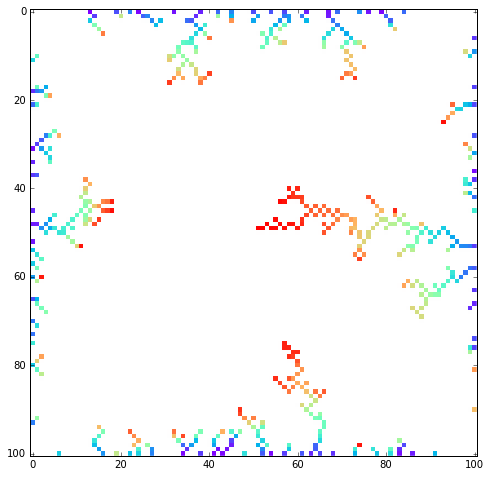

In [6]:
src1 = Type1Source()
dla1 = Type1DLA()

while not dla1.stop:
    dla1.evolve(src1)

dla1.draw('color')

Inoltre è possibile effettuare una animazione del sistema visualizzando gli step intermedi.

In [7]:
# adapted from http://matplotlib.org/1.4.1/examples/animation/dynamic_image2.html
fig = plt.figure()

ani_src1 = Type1Source()
ani_dla1 = Type1DLA()

ims1 = []
while not ani_dla1.stop:
    ani_dla1.evolve(ani_src1)
    im = ani_dla1.draw('color')
    ims1.append([im])

anim = animation.ArtistAnimation(fig, ims1, interval=50, blit=True)
anim.save('media/dla1.mp4', fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
plt.close(fig)
video('media/dla1.mp4')

## Configurazione 2

Nella seconda configurazione lo stato iniziale del sistema ed i siti di emissione giocano parti invertite rispetto alla prima. Infatti in questa configurazione lo stato iniziale consiste di un unico sito occupato nel centro (ovviamente circondato da siti appiccicosi) e la matrice del sistema ha la seguente forma

\begin{pmatrix}
0       & 0      & \cdots &        &        &        & 0      \\ 
0       & \ddots &        &        &        &        & \vdots \\
\vdots  &        & 2      & 2      & 2      &        &        \\
        &        & 2      & 1      & 2      &        &        \\
        &        & 2      & 2      & 2      &        &        \\
        &        &        &        &        & \ddots &        \\
0       & \cdots &        &        &        &        & 0       
\end{pmatrix}

mentre le sorgenti sono disposte sugli spigoli del reticolo. 

Tuttavia la simulazione diretta di una configurazione di questo genere consumerebbe molto tempo di calcolo e risulterebbe impraticabile, infatti le chance che una particelle prodotta nella periferia del reticolo si propaghi fino al centro di quest'ultimo sono molto ridotte.

Per ovviare a questo problema è sufficiente osservare la seguente. Si consideri un contorno sul reticolo tale che contenga al suo interno i siti appiccicosi al centro di quest'ultimo. Una particella, dopo essere stata emessa sui bordi del reticolo e prima di intercettare un sito appiccicoso, deve attraversare questo contorno. Pertanto, nella ipotesi in cui la particella attraversi con uguale probabilità i punti del contorno, si può immaginare che sia stata creata proprio da uno di essi.

Pertanto nella simulazione di questa configurazione la geometria dei siti di emissione evolve per tenere conto di questo accorgimento.

In [8]:
class Type2Source(Source):
    
    def __init__(self):
        fake_grid = np.zeros([2*n+1,2*m+1],dtype=int)
        fake_grid[n,m] = 1
        self.update(fake_grid)
    
    def update(self,dlagrid):
        self.grid = np.zeros([2*m+1,2*n+1],dtype=int)
        i, j = np.where(dlagrid == 1)
        imin, imax = max(0,i.min()-2), min(2*n,i.max()+2)
        jmin, jmax = max(0,j.min()-2), min(2*m,j.max()+2)
        self.grid[imin:imax,jmin] = self.grid[imin:imax,jmax] = 1
        self.grid[imin,jmin:jmax] = self.grid[imax,jmin:jmax] = 1
        self.grid[imax,jmax] = 1

        i, j = np.where(self.grid != 0)
        self.sitelist = list(zip(i,j))
        self.sitenumber = len(self.sitelist)


class Type2DLA(DLAProcess):
    
    def __init__(self):
        seed = [[2,2,2],[2,1,2],[2,2,2]]
        self.grid = np.zeros([2*n+1,2*m+1],dtype=int)
        self.grid[n-1:n+2,m-1:m+2] = seed
        
        self.agegrid = np.zeros([2*n+1,2*m+1],dtype=int)
        self.agegrid[n,m] = 1
        self.counter = 2
        self.stop = False

Tutte le differenze rispetto alla configurazione precedente sono contenute nella implementazione delle sottoclassi relative, pertanto è possibile visualizzare il nuovo stato finale del sistema utilizzando praticamente lo stesso codice.

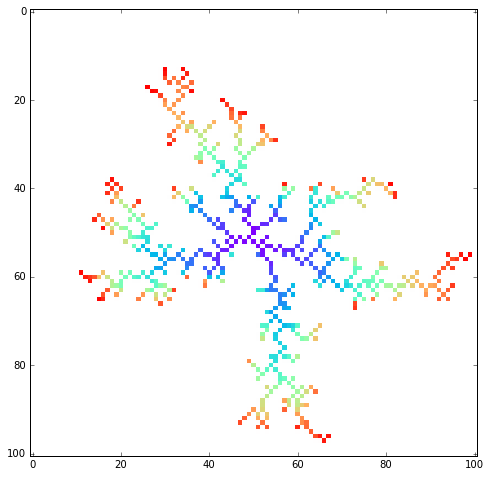

In [9]:
src2 = Type2Source()
dla2 = Type2DLA()

while not dla2.stop:
    dla2.evolve(src2)

dla2.draw('color')

Osservazioni analoghe valgono per la animazione del sistema

In [10]:
fig = plt.figure()

ani_src2 = Type2Source()
ani_dla2 = Type2DLA()

ims2 = []
while not ani_dla2.stop:
    ani_dla2.evolve(ani_src2)
    im = ani_dla2.draw('color')
    ims2.append([im])

anim = animation.ArtistAnimation(fig, ims2, interval=50, blit=True)
anim.save('media/dla2.mp4', fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
plt.close(fig)
video('media/dla2.mp4')

Purtroppo non è pratico simulare griglie più grandi di $101 \times 101$. Una implementazione dello stesso algoritmo in [Julia](http://julialang.org/) impiega circa un minuto per una griglia $401 \times 401$.

In [12]:
!julia dla.jl 200 200 media/dla.png

<img src="media/dla.png"></img>